[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_ripening_rate.ipynb.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_ripening_rate.ipynb.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_ripening_rate.ipynb.ipynb)

### based on figures from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import os
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import si
from PySDM.products import ParcelDisplacement, AmbientRelativeHumidity, RipeningRate
from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

In [3]:
products = (
    ParcelDisplacement(name='z'),
    AmbientRelativeHumidity(name='S_max', unit='%', var='RH'),
    RipeningRate(name='ripening')
)

vertical_velocity = ("0.25","1","4")
output = {
    velocity: {
        case: Simulation(Settings(
            vertical_velocity=float(velocity),
            dt=1*si.s if 'CI' not in os.environ else 50 * si.s,
            n_sd=200 if 'CI' not in os.environ else 10,
            aerosol=case
        ), products=products).run()
        for case in ("pristine", "polluted")
    }
    for velocity in vertical_velocity
}

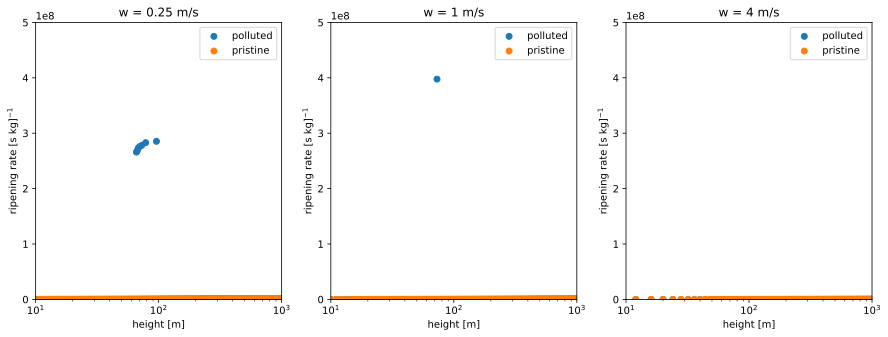

HTML(value="<a href='./fig_ripening.pdf' target='_blank'>./fig_ripening.pdf</a><br>")

In [4]:
fig, axs = pyplot.subplots(1, 3, figsize=(15, 5))

for aerosol in ("polluted", "pristine"):
    for i, velocity in enumerate(vertical_velocity):
        axs[i].scatter(
            output[velocity][aerosol]['products']['z'],
            output[velocity][aerosol]['products']['ripening']
        )
        axs[i].set_title("w = " + velocity+" m/s")

for ax in axs:
    ax.set_xlim(10, 1000)
    ax.set_ylim(0, 5e8)
    ax.set_xscale('log')
    ax.set_xlabel('height [m]')
    ax.set_ylabel('ripening rate [s kg]$^{-1}$')
    ax.legend(["polluted", "pristine"])
show_plot("fig_ripening.pdf")

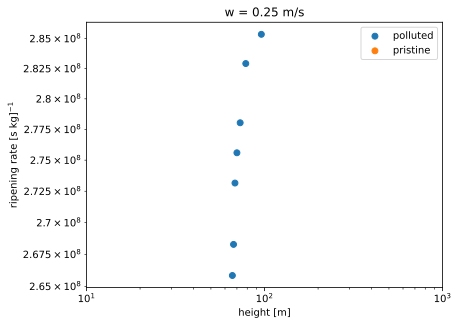

HTML(value="<a href='./fig_ripening_zoom.pdf' target='_blank'>./fig_ripening_zoom.pdf</a><br>")

In [6]:
for aerosol in ("polluted", "pristine"):
    pyplot.scatter(
        output["0.25"][aerosol]['products']['z'],
        output["0.25"][aerosol]['products']['ripening']
    )
pyplot.title("w = 0.25 m/s")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlim(10, 1000)
pyplot.xlabel('height [m]')
pyplot.ylabel('ripening rate [s kg]$^{-1}$')
pyplot.legend(["polluted", "pristine"])
show_plot('fig_ripening_zoom.pdf')